# okay so, what is the goal of today? 
I think the goal is to write a fn to calculate the partition fn at each B val, then write fns to use that partition to calculate magnetization, susceptibility

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PyCrystalField as cef
import scipy
from scipy.misc import derivative
import lmfit
import pandas as pd




 *******************************************************
 *                PyCrystalField 2.3.9                 *
 *  Please cite  J. Appl. Cryst. (2021). 54, 356-362   * 
 *    <https://doi.org/10.1107/S160057672001554X>      *
 *******************************************************



In [130]:
temperature = 5 # in K

muB = 5.7883818012e-2  # meV/T
mu0 = np.pi*4e-7       # T*m/A
kB  = 8.617e-2         # [meV/K]
meVToCm =meVTocCmInv= 8.066 
ion = 'Er3+'

# # my values from fit
B20 = -0.04910422
B40 =  -3.6483e-04
B43 = -0.01474077
B60 =  3.1547e-06
B63 =  3.2378e-06
B66 =  4.2797e-05

# B20 = -0.04241571
# B40 =  -3.7243e-04
# B43 = -0.01415944
# B60 =  3.2072e-06
# B63 =  -9.4035e-07
# B66 =  3.5789e-05


# neutron fit vals
# B20 = -3.559e-2
# B40 = -3.849e-4
# B43 = -1.393e-2
# B60 = 3.154e-6
# B63 = -4.695e-6
# B66 = 3.3815e-5

g = cef.LandeGFactor(ion)
Bparams =  {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
ErObj = cef.CFLevels.Bdict(ion,Bparams)
ionObj = ErObj

kBT = kB*temperature

Jperp = -0.2e-3 #meV
Jz = -2.5e-3 #meV
q= 6


In [3]:
def findIdx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# start with XXZ 

In [4]:
[a+b for a,b in zip([4,5,6], [1,1,0])]


[5, 6, 6]

In [100]:
gj = 1.2
def zeemanCEF(ionObj, ion, Field, Temp = 2): 
    JdotB = (muB*(Field[0]*cef.Operator.Jx(ionObj.J) + Field[1]*cef.Operator.Jy(ionObj.J))*1.2 + Field[2]*cef.Operator.Jz(ionObj.J))*1.2
    H = np.sum([a*b for a,b in zip(ionObj.O, ionObj.B)], axis=0)
    ionObj.diagonalize(H + JdotB.O) # this is just H = Hcef + Hmag
    # okay, so now let's add a mean field term??
    # fuck
    numIter = 10 
    for i in range(1, numIter): 
        # magexpVal = ionObj.magnetization(ion, Temp, Field)
        # magexpVal = -1*magexpVal
        evals = ionObj.eigenvaluesNoNorm
        evecs = ionObj.eigenvectors
        JexpVals = np.zeros((len(evals),3))
        for i, ev in enumerate(evecs):
            kev = cef.Ket(ev)
            # print np.real(np.dot(ev,kev.Jy().ket)), np.real(np.dot(ev,np.dot(Jy.O,ev)))
            # print np.real(kev*kev.Jy()) - np.real(np.dot(ev,np.dot(Jy.O,ev)))
            JexpVals[i] =[np.real(kev*kev.Jx()),
                          np.real(kev*kev.Jy()),
                          np.real(kev*kev.Jz())]
        Zz = np.sum(np.exp(-evals/(kB*Temp)))
        JexpVal = np.dot(np.exp(-evals/(kB*Temp)),JexpVals)/Zz
        fieldInt = [a*b for a,b in zip([6*Jperp/(muB**2*gj**2)**2, 6*Jperp/(muB**2*gj**2)**2,  6*Jz/(muB**2*gj**2)], JexpVal)]
        Beff = [a+b for a,b in zip(Field, fieldInt)] 
        JdotBeff = (muB*Beff[0]*cef.Operator.Jx(ionObj.J) + Beff[1]*cef.Operator.Jy(ionObj.J))*1.2 + Beff[2]*cef.Operator.Jz(ionObj.J)*1.2
        ionObj.diagonalize(H + JdotBeff.O)
    return ionObj


In [6]:
obj = zeemanCEF(ErObj, ion, [0,0,1], Temp = 2)
obj.magnetization(ion, 2, [0,0,1])

array([-5.99942641e-16,  0.00000000e+00,  8.99130232e+00])

In [45]:
def meanField(ionObj, field):
    H = np.sum([a*b for a,b in zip(ionObj.O, ionObj.B)], axis=0)
    # ionObj.diagonalize(H)
           
    return ionObj

In [46]:
obj = meanField(ErObj, [0,0,1])
obj.eigenvalues

array([  0.        ,  22.90814665,  51.95164722,  78.98361089,
       101.42720129, 120.0600992 , 136.98571603, 154.7451993 ,
       175.44375225, 199.66734933, 225.99507   , 251.7906382 ,
       274.41120829, 291.73503747, 305.3616175 , 324.40480782])

In [ ]:
field = [[0,0,i] for i in np.linspace(-10,10, 500)]
for x in xxz.T: 
    plt.plot(np.array(field).T[2], x)

plt.grid(True)
plt.title('IR Lines, with XXZ shift')
# plt.xlim(-1,0)
# plt.ylim(-25,0)


In [133]:
def newfreeEnergy(field=[0,0,0], temperature=1, ionObj = ErObj): 
    try: 
        kBT= kB*temperature
        ionObj = zeemanCEF(ionObj, ion, field, temperature)
        evals = ionObj.eigenvalues#NoNorm#xxzShift(ionObj)
        # Emin - min(evals)
        # E =[eval-Emin for eval in evals]
        Z = [np.exp(-Ei/kBT) for Ei in evals]
        Z = sum(Z)
        f = -kBT*np.log(Z) 
    except: 
        f =[]
        for b in field: 
            kBT= kB*temperature
            if temperature ==0: 
                temperature = 1e-10
                kBT= kB*temperature
            ionObj = zeemanCEF(ionObj, ion, b, temperature)
            evals = ionObj.eigenvalues#NoNorm
            E =[eval for eval in evals]
            minE = min(E)
            # E = [e-minE for e in E]
            Z = [np.exp(-Ei/kBT) for Ei in evals]
            Z = sum(Z)
            f.append(-kBT*np.log(Z))
            # f.append(Z)
    return f

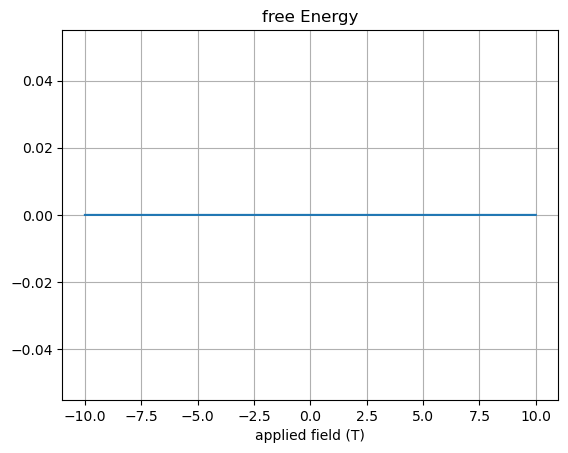

In [134]:
f = newfreeEnergy(field, temperature=5)
plt.plot(np.array(field).T[2], f)
plt.title('free Energy')
plt.xlabel('applied field (T)')
# plt.ylim(0,10e180)
plt.grid(True)
# plt.yscale('log')
# plt.xlim(-1, 1)
# plt.ylim(-14,-11)


# okay, so now we want to do the same free energy, magnetization, etc., plots with the xxz correction

In [102]:
field = [[0,0,i] for i in np.linspace(-10,10, 1000)]

In [156]:
def newnumericalmagnetization(lowfield, highfield, ionObj = ErObj, temperature = 1, numpoints = 3000): 
    b, dx = np.linspace(lowfield,highfield,numpoints, retstep=True)
    field = [[0,0,i] for i in b]
    gJ = 1.2
    # f = newfreeEnergy(field, temperature)
    # m = -np.gradient(f, dx)
    # m = np.array([ionObj.magnetization(ion, temperature, f)*-1 for f in field])
    m = []
    for f in field:
        ionObj = zeemanCEF(ionObj, ion, f, temperature)
        evals = ionObj.eigenvaluesNoNorm
        evecs = ionObj.eigenvectors
        JexpVals = np.zeros((len(evals),3))
        for i, ev in enumerate(evecs):
            kev = cef.Ket(ev)
            # print np.real(np.dot(ev,kev.Jy().ket)), np.real(np.dot(ev,np.dot(Jy.O,ev)))
            # print np.real(kev*kev.Jy()) - np.real(np.dot(ev,np.dot(Jy.O,ev)))
            JexpVals[i] =[np.real(kev*kev.Jx()),
                          np.real(kev*kev.Jy()),
                          np.real(kev*kev.Jz())]
        Zz = np.sum(np.exp(-evals/(kB*temperature)))
        JexpVal = np.dot(np.exp(-evals/(kB*temperature)),JexpVals)/Zz
        m.append(np.nan_to_num(JexpVal*gJ))
    return m,dx, field

def newnumericalsusceptibility(fieldVal, temps):
    chi = []
    for temp in temps: 
        # f = newfreeEnergy(field, temp)
        # m = np.gradient(f, dx)
        m, dx, field = newnumericalmagnetization(1-fieldVal,1+fieldVal, temperature = temp, numpoints =100)
        m = np.array(m).T
        x = np.gradient(m[2], dx) 
        # now we've gotta access the very low field value
        valIdx = findIdx(field, [0,0,fieldVal])
        #chi.append(x[valIdx])
        chi.append(x[2])
    return chi

In [157]:
 m,dx, field = newnumericalmagnetization(-10,10, temperature = 2)
m= np.array(m).T

In [155]:
m

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       ...,
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

In [120]:
fname  = '/Users/hopeless/Desktop/LeeLab/data/CsErSe2_MTall.dat'
data = pd.read_csv(fname, delimiter='\t')

In [121]:
data

,Unnamed: 0,1 T H//ab,Unnamed: 2,Unnamed: 3,Unnamed: 4,5 T H//ab,Unnamed: 6,Unnamed: 7,Unnamed: 8,3 T H//ab,...,Unnamed: 28,5 T H//c,Unnamed: 30,3 T H//c,Unnamed: 32,0.5 T H//c,Unnamed: 34,0.2 T H//c,Unnamed: 36,0.1 T H//c
0,349.983300,0.033338,350.0013,0.0334361530621543,50.00362,0.202160978998095,50.00027,0.201014389131886,1.999505,2.76524671644286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,349.983300,0.033319,349.9714,0.0334515970538686,49.99248,0.201957240463333,49.99916,0.200945388518057,1.999642,2.76451639886857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,349.983300,0.033328,348.9132,0.0335348794335943,49.58734,0.203569697903333,49.58627,0.202635170621657,2.442433,2.43102564761714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,349.977400,0.033310,348.7474,0.0335508731267086,49.31949,0.204611338429238,49.32603,0.203760644973771,2.665923,2.28749075920000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,349.977400,0.033310,347.8738,0.0336637660885143,49.03831,0.205797733657143,49.03188,0.204894181613086,2.877166,2.18227529361429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,2.433234,2.047201,--,--,--,--,--,--,--,--,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
816,1.999695,2.216667,--,--,--,--,--,--,--,--,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
817,1.999694,2.215822,--,--,--,--,--,--,--,--,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
818,1.998607,2.228159,--,--,--,--,--,--,--,--,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
# m= np.array(m).T
# m[2]
# np.savetxt('magnetization.txt', m)
# field = np.array(field).T[2]
magPCF = np.array([ErObj.magnetization(ion, 2, f)*-1 for f in field]).T[2]

Text(0, 0.5, 'magnetization (uB/Er)')

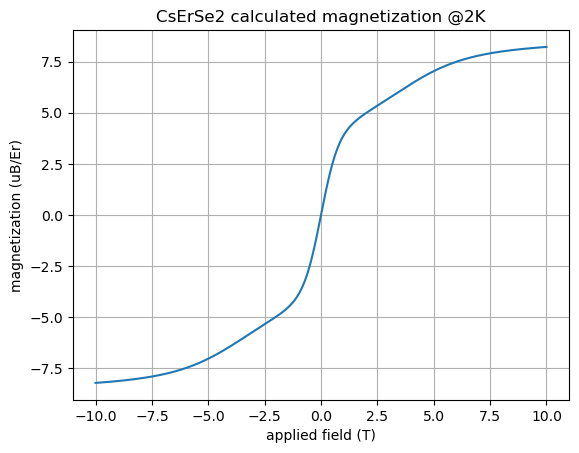

In [159]:
# m= np.array(m).T
# plt.plot(np.linspace(-10,10,len(m[2])), m[2], label = 'MFT')
plt.plot(np.linspace(-10,10, len(magPCF)), magPCF, label = 'pcf')
# plt.plot(m)
plt.grid(True)
# plt.ylim(-.6,0.6)
# plt.xlim(-2.5,2.5)
# plt.legend()
plt.title('CsErSe2 calculated magnetization @2K')
plt.xlabel('applied field (T)')
plt.ylabel('magnetization (uB/Er)')

In [116]:
temps = np.linspace(10,300,100)
chi = newnumericalsusceptibility(1, temps)

Text(0.5, 0, 'Temperature (K)')

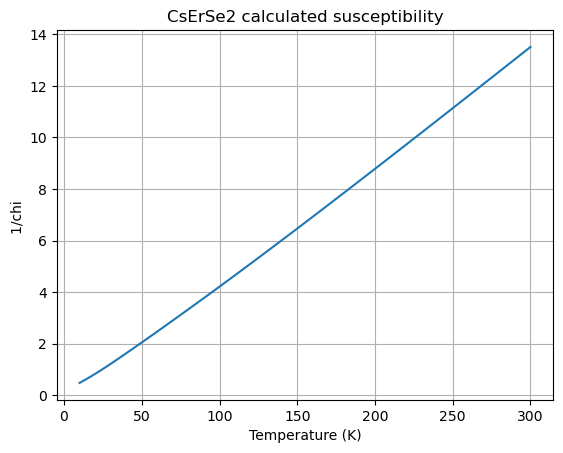

In [117]:
chiinv = [1/x for x in chi]
plt.plot(temps, chiinv)
# plt.plot(temps, 1/temps)
plt.grid(True)
plt.title('CsErSe2 calculated susceptibility')
plt.ylabel('1/chi ')
plt.xlabel('Temperature (K)')
# plt.xlim(100,300)

# QFI 4 fun

In [ ]:
def rho(evecs, evals): 
    # evals = ionObj.eigenvaluesNoNorm
    # evecs = ionObj.eigenvectors
    p = np.dot(evals[0], np.outer(evecs[0], evecs[0]))
    for i in range(1, len(evals)): 
        p+=np.dot(evals[i], np.outer(evecs[i], evecs[i]))
    return p

    

In [ ]:
def f(o, do): 
    ionObj = zeemanCEF(ErObj, ion, [0,0,o])
    evals = xxzShift(ionObj)
    dionObj = zeemanCEF(ErObj, ion, [0,0,o+do])
    devals = xxzShift(ionObj)
    M = np.sqrt(rho(ionObj.eigenvectors, evals)) +rho(dionObj.eigenvectors, devals) +np.sqrt(rho(ionObj.eigenvectors, evals)) 
    f = np.trace(M)
    return np.real(f)

In [ ]:
def Z(evals, temp): 
    kBT = kB*temp
    E =[eval for eval in evals]
    Z = [np.exp(-Ei/kBT) for Ei in E]
    return np.nansum(Z)
    if kBT == 0: 
        Z = 1
    return Z


def F(o,do, temp): 
    # do = 1e-6
    ionObj = zeemanCEF(ErObj, ion, [0,0,o])
    evals = ionObj.eigenvaluesNoNorm
    dionObj = zeemanCEF(ErObj, ion, [0,0,o+do])
    devals = dionObj.eigenvaluesNoNorm
    z = Z(evals, temp)
    dz = Z(devals, temp)
    # this needs to be rewritten lol
    kBT = kB*temp
    top = 0
    for e in evals: 
        for de in devals: 
            t = (-e-de)/(2*kBT)
            t = np.exp(t)
            top = top+t
    # F = np.sqrt((np.sqrt(z)*np.sqrt(dz))/(z*np.sqrt(dz)))
    F = np.real(np.sqrt(top/(z*np.sqrt(dz))))
    return F


In [ ]:
# def F(o, do, beta): 
    
#     return f(o, do)

In [ ]:
def fischerSus(targetField, temps): 
    b = targetField
    sus = []
    for t in temps: 
        # do first derivative
        # taking derivative wrt depsilon
        h = 1e-3
        do =1e-3
        dd02 = (2*np.log(F(targetField, do, t))-np.log(F(targetField, do-h, t))-np.log(F(targetField, do+h, t)))/(h**2)
        # dd02 = (F(targetField, do-h, t)-F(targetField, do+h, t))/h
        sus.append(dd02)
    return sus

In [ ]:
# t = 1
# h = 1e-3
# do =1e-3
# targetField = 10
# dd02 = (2*F(targetField, do, t)-F(targetField, do-h, t)-F(targetField, do+h, t))/(h**2)
# d = (-F(targetField, do-h, t))#-F(targetField, do+h, t))
# print(dd02)
# print(d)
temps = np.linspace(1,200,100)
sus = fischerSus(.001, temps)
# f = [F(1,.1, t)for t in temps]
# f2 = [F(1,.001, t)for t in temps]
# plt.plot(temps, f)
# plt.plot(temps, f2)

In [ ]:
susinv = [1/s for s in sus]
plt.plot(temps, susinv)
# plt.yscale('log')

# PCF

Text(0, 0.5, 'mag')

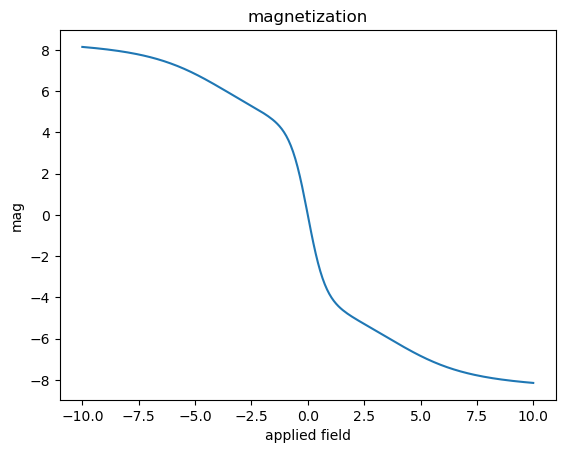

In [50]:

g = cef.LandeGFactor(ion)
Bparams =  {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
ErObj = cef.CFLevels.Bdict(ion,Bparams)

field = [[0,0,b] for b in np.linspace(-10,10,200)]
mag = np.array([ionObj.magnetization(ion, 2, f) for f in field])
field = np.array(field).T

plt.plot(field[2], mag.T[2])
plt.title('magnetization')
plt.xlabel('applied field')
plt.ylabel('mag')


Text(0, 0.5, '1/chi')

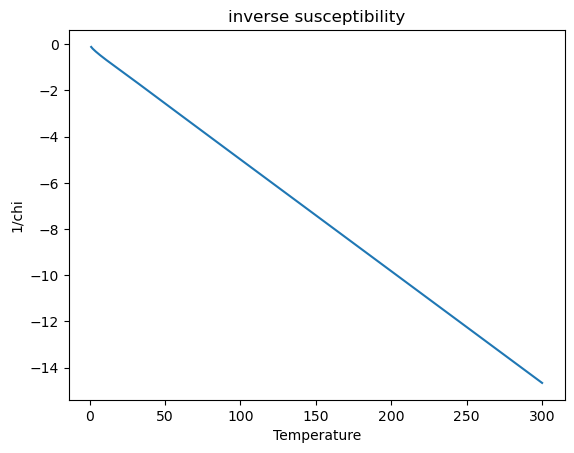

In [51]:
temps = np.linspace(0,300,300)
field = .1
df = 0.001
sus = ErObj.susceptibility(ion, temps, field, df)
susinv = [1/x for x in sus]
plt.plot(temps, susinv)
plt.title('inverse susceptibility')
plt.xlabel('Temperature')
plt.ylabel('1/chi')